In [3]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.tree
import sklearn.metrics
import sklearn.ensemble
import sklearn.preprocessing
import sklearn.model_selection   # For cross_val_score, GridSearchCV, RandomizedSearchCV
import pandas as pd
plt.rcParams.update({'figure.max_open_warning': 0})

In [25]:
#training as y target values of y = tomororrow_is_buy
data = pd.read_csv('out.csv')
data.drop(data.columns[data.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
data = data.dropna(axis=1)
X = data.drop(["date","ticker","tomorrw_is_buy","tomorrow_is_strong_buy","week_is_buy","week_is_strong_buy","4week_is_buy","4week_is_strong_buy"],axis=1)
y = data.tomorrw_is_buy
X = X.values
y = y.values
#data.head()



/usr/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (30,31) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


[531, 40, 531, 531, 81, 46, 531, 46, 153, 70, 531, 531, 531, 35, 46, 531, 46, 1018, 229087, 2010, 19798, 2010, 454, 35, 35, 35, 35, 35, 35, 36, 36, 541, 783, 57, 7, 1405, 31, 31, 1890, 1405, 12, 40, 868, 17, 46, 46, 21, 5148, 32, 32, 32, 32, 1843, 228, 32, 533, 86, 533, 533, 4613, 4613, 721, 32, 330, 2, 2647, 2647, 991, 1843, 8, 21, 71, 71, 18, 21, 1347, 3940, 3137, 18, 1347, 46, 21, 21, 3137, 5372, 5372, 932, 41, 5372, 41, 5372, 5372, 5372, 41, 815, 75, 10, 10141, 10, 4]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]


In [6]:
%%time
for i in range(1000000):  # Burn some CPU cycles in a
    pass                  # loop that does nothing

CPU times: user 31.4 ms, sys: 391 µs, total: 31.8 ms
Wall time: 30.8 ms


In [7]:
#split data into 60-20-20
#test set
x_remaining, Xtest, y_remaining, ytest = sklearn.model_selection.train_test_split(X, y, test_size=0.20,
                                                                                  random_state=0)
#validation and training set
Xtrn, Xval, ytrn, yval = sklearn.model_selection.train_test_split(x_remaining, y_remaining, test_size=0.25,
                                                                  random_state=0)
print(Xtrn.shape,Xval.shape,ytrn.shape,yval.shape)

(240956, 20) (80319, 20) (240956,) (80319,)


In [8]:
#scaling values 
scaler = sklearn.preprocessing.StandardScaler()
X_trn = scaler.fit_transform(Xtrn.reshape(Xtrn.shape[0],-1))
X_test = scaler.transform(Xtest.reshape(Xtest.shape[0],-1))
X_val = scaler.transform(Xval.reshape(Xval.shape[0],-1))

In [9]:
import importlib
def train_estimators(X, y, estimator_type, param_name, param_vals, **kwargs):
    train_estimator = [] 
    s = "%s" %kwargs #converts kwargs to string 
    s = str(estimator_type).split("'")[1]      #gets import_module which is sklearn.tree 
    position1 = (s.find("."))
    position2 = (s.find(".",position1+1))
    
    for i in range(len(param_vals)):
        model_class = getattr(importlib.import_module(s[:position2]),(str(estimator_type).split(".")[-1][:-2]))
        kwargs[param_name] = param_vals[i] #adds param_name into the kwargs dictionnary
        model = model_class(**kwargs)  # instantiates the model
        train_estimator.append(model.fit(X,y))
        print(f' Training {train_estimator[i]}...')
    return train_estimator

In [10]:
def score_estimators(X, y, estimators):
    score = []
    for i in range(np.array(estimators).shape[0]):
         score.append(estimators[i].score(X,y))
    return score

In [11]:
def plot_estimator_scores(estimators, param_name, param_vals):
    train_score,val_score,test_score = [],[],[]
    train_score = score_estimators(X_trn,ytrn,estimators)
    val_score = score_estimators(X_val, yval, estimators)
    test_score = score_estimators(X_test, ytest, estimators)
    #finding best scores  
    best_train = max(np.array(train_score))
    best_val = max(np.array(val_score))
    best_test = max(np.array(test_score))
    min_score = np.concatenate((train_score,val_score,test_score))
    best_score = np.concatenate((train_score,val_score,test_score))
    #plotting code
    #makes sure the x axis points are evenly spaced
    locs, labels = plt.xticks() 
    plt.plot(locs,np.array(train_score).ravel(),'-ok',color='green',label='train = %.3f' %(best_train))
    plt.plot(locs,val_score,'-ok',color='red',label='validate = %.3f' %(best_val))
    plt.plot(locs,test_score,linestyle='dotted',color='black',label='test = %.3f' %(best_test))
    plt.scatter(locs[val_score.index(best_val)],best_val, s=150, marker='x',color="red")
    plt.xticks(locs,param_vals)
    plt.ylim(min(min_score)-0.02,max(best_score)+0.01)
    plt.legend(loc="upper left")
    plt.xlabel(param_name)
    plt.ylabel("score")
    plt.title(f'{estimators[0].__class__.__name__} score vs {param_name}')

 Training DecisionTreeClassifier(max_depth=1, random_state=0, splitter='random')...


 Training DecisionTreeClassifier(max_depth=5, random_state=0, splitter='random')...


 Training DecisionTreeClassifier(max_depth=10, random_state=0, splitter='random')...


 Training DecisionTreeClassifier(max_depth=20, random_state=0, splitter='random')...


 Training DecisionTreeClassifier(max_depth=50, random_state=0, splitter='random')...


 Training DecisionTreeClassifier(max_depth=100, random_state=0, splitter='random')...


CPU times: user 4.42 s, sys: 29.4 ms, total: 4.45 s
Wall time: 4.41 s


/tmp/ipykernel_338731/2343653756.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-ok" (-> color='k'). The keyword argument will take precedence.
  plt.plot(locs,np.array(train_score).ravel(),'-ok',color='green',label='train = %.3f' %(best_train))
/tmp/ipykernel_338731/2343653756.py:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-ok" (-> color='k'). The keyword argument will take precedence.
  plt.plot(locs,val_score,'-ok',color='red',label='validate = %.3f' %(best_val))


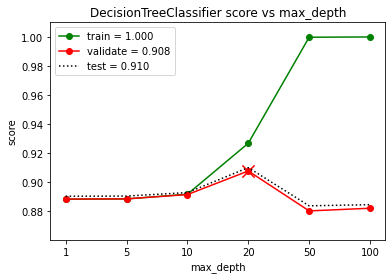

In [12]:
%%time
tree_estimators = train_estimators(X_trn, ytrn, sklearn.tree.DecisionTreeClassifier,
                                   'max_depth', [1, 5, 10, 20, 50, 100], splitter='random', random_state=0)
plot_estimator_scores(tree_estimators,'max_depth',[1, 5, 10, 20, 50, 100])

In [13]:
%%time
forest = train_estimators(X_trn, ytrn, sklearn.ensemble.RandomForestClassifier,
                                   'max_depth', [1, 5, 10, 20, 50, 100], random_state=0)

 Training RandomForestClassifier(max_depth=1, random_state=0)...


 Training RandomForestClassifier(max_depth=5, random_state=0)...


 Training RandomForestClassifier(max_depth=10, random_state=0)...


 Training RandomForestClassifier(max_depth=20, random_state=0)...


 Training RandomForestClassifier(max_depth=50, random_state=0)...


 Training RandomForestClassifier(max_depth=100, random_state=0)...
CPU times: user 7min 48s, sys: 197 ms, total: 7min 49s
Wall time: 7min 49s


CPU times: user 30 s, sys: 33.3 ms, total: 30 s
Wall time: 30 s


/tmp/ipykernel_338731/2343653756.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-ok" (-> color='k'). The keyword argument will take precedence.
  plt.plot(locs,np.array(train_score).ravel(),'-ok',color='green',label='train = %.3f' %(best_train))
/tmp/ipykernel_338731/2343653756.py:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-ok" (-> color='k'). The keyword argument will take precedence.
  plt.plot(locs,val_score,'-ok',color='red',label='validate = %.3f' %(best_val))


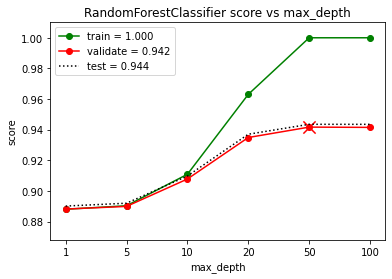

In [14]:
%%time
plot_estimator_scores(forest,'max_depth',[1, 5, 10, 20, 50, 100])

 Training LogisticRegression(C=1e-05, max_iter=10000, random_state=0)...


 Training LogisticRegression(C=0.0001, max_iter=10000, random_state=0)...


 Training LogisticRegression(C=0.001, max_iter=10000, random_state=0)...


 Training LogisticRegression(C=0.01, max_iter=10000, random_state=0)...


 Training LogisticRegression(C=0.1, max_iter=10000, random_state=0)...


 Training LogisticRegression(max_iter=10000, random_state=0)...


CPU times: user 7.55 s, sys: 4.13 s, total: 11.7 s
Wall time: 3.12 s


/tmp/ipykernel_338731/2343653756.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-ok" (-> color='k'). The keyword argument will take precedence.
  plt.plot(locs,np.array(train_score).ravel(),'-ok',color='green',label='train = %.3f' %(best_train))
/tmp/ipykernel_338731/2343653756.py:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-ok" (-> color='k'). The keyword argument will take precedence.
  plt.plot(locs,val_score,'-ok',color='red',label='validate = %.3f' %(best_val))


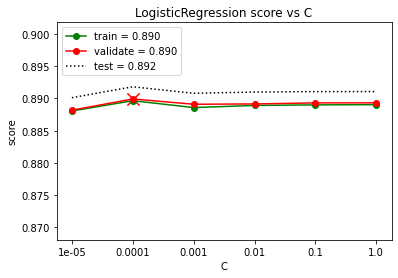

In [15]:
%%time
logistic = train_estimators(X_trn, ytrn, sklearn.linear_model.LogisticRegression,
                                   'C', [1e-05, 0.0001, 0.001, 0.01, 0.1,1.0], max_iter=10000,random_state=0)
plot_estimator_scores(logistic,'C',[1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0])

In [17]:
%%time
import warnings
warnings.filterwarnings('ignore', 'Solver terminated early.*')
svm = train_estimators(X_trn, ytrn, sklearn.svm.SVC,
                                   'C', [0.01, 0.1,1.0, 10.0, 100.0,1000.0], gamma=0.001,max_iter=1000,random_state=0)

 Training SVC(C=0.01, gamma=0.001, max_iter=1000, random_state=0)...


 Training SVC(C=0.1, gamma=0.001, max_iter=1000, random_state=0)...


 Training SVC(gamma=0.001, max_iter=1000, random_state=0)...


 Training SVC(C=10.0, gamma=0.001, max_iter=1000, random_state=0)...


 Training SVC(C=100.0, gamma=0.001, max_iter=1000, random_state=0)...


 Training SVC(C=1000.0, gamma=0.001, max_iter=1000, random_state=0)...
CPU times: user 1min 52s, sys: 426 ms, total: 1min 53s
Wall time: 1min 53s


CPU times: user 3min 40s, sys: 46 ms, total: 3min 40s
Wall time: 3min 40s


/tmp/ipykernel_338731/2343653756.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-ok" (-> color='k'). The keyword argument will take precedence.
  plt.plot(locs,np.array(train_score).ravel(),'-ok',color='green',label='train = %.3f' %(best_train))
/tmp/ipykernel_338731/2343653756.py:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-ok" (-> color='k'). The keyword argument will take precedence.
  plt.plot(locs,val_score,'-ok',color='red',label='validate = %.3f' %(best_val))


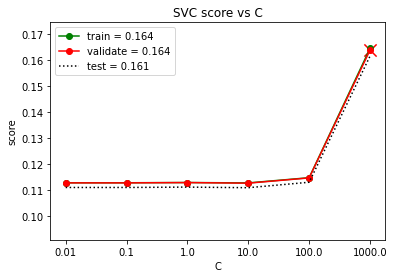

In [18]:
%%time
plot_estimator_scores(svm,'C',[0.01, 0.1,1.0, 10.0, 100.0,1000.0])

In [15]:
X = data.drop(["date","ticker","tomorrw_is_buy","tomorrow_is_strong_buy","week_is_buy","week_is_strong_buy","4week_is_buy","4week_is_strong_buy"],axis=1)
y = data.week_is_buy
X = X.values
y = y.values
#split data into 60-20-20
#test set
x_remaining, Xtest, y_remaining, ytest = sklearn.model_selection.train_test_split(X, y, test_size=0.20,
                                                                                  random_state=0)
#validation and training set
Xtrn, Xval, ytrn, yval = sklearn.model_selection.train_test_split(x_remaining, y_remaining, test_size=0.25,
                                                                  random_state=0)

#scaling values 
scaler = sklearn.preprocessing.StandardScaler()
X_trn = scaler.fit_transform(Xtrn.reshape(Xtrn.shape[0],-1))
X_test = scaler.transform(Xtest.reshape(Xtest.shape[0],-1))
X_val = scaler.transform(Xval.reshape(Xval.shape[0],-1))

 Training DecisionTreeClassifier(max_depth=1, random_state=0, splitter='random')...
 Training DecisionTreeClassifier(max_depth=5, random_state=0, splitter='random')...
 Training DecisionTreeClassifier(max_depth=10, random_state=0, splitter='random')...
 Training DecisionTreeClassifier(max_depth=20, random_state=0, splitter='random')...
 Training DecisionTreeClassifier(max_depth=50, random_state=0, splitter='random')...
 Training DecisionTreeClassifier(max_depth=100, random_state=0, splitter='random')...
CPU times: user 11.7 s, sys: 368 ms, total: 12.1 s
Wall time: 14.5 s


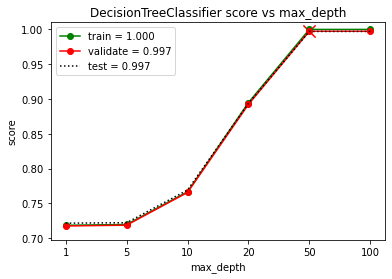

In [16]:
%%time
tree_estimators = train_estimators(X_trn, ytrn, sklearn.tree.DecisionTreeClassifier,
                                   'max_depth', [1, 5, 10, 20, 50, 100], splitter='random', random_state=0)
plot_estimator_scores(tree_estimators,'max_depth',[1, 5, 10, 20, 50, 100])

In [17]:
%%time
forest = train_estimators(X_trn, ytrn, sklearn.ensemble.RandomForestClassifier,
                                   'max_depth', [1, 5, 10, 20, 50, 100], random_state=0)

 Training RandomForestClassifier(max_depth=1, random_state=0)...
 Training RandomForestClassifier(max_depth=5, random_state=0)...
 Training RandomForestClassifier(max_depth=10, random_state=0)...
 Training RandomForestClassifier(max_depth=20, random_state=0)...
 Training RandomForestClassifier(max_depth=50, random_state=0)...
 Training RandomForestClassifier(max_depth=100, random_state=0)...
CPU times: user 3min 52s, sys: 3.29 s, total: 3min 55s
Wall time: 4min 7s


CPU times: user 29.1 s, sys: 970 ms, total: 30 s
Wall time: 31.4 s


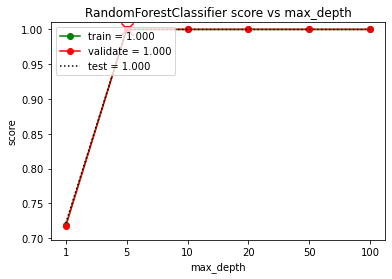

In [18]:
%%time
plot_estimator_scores(forest,'max_depth',[1, 5, 10, 20, 50, 100])

 Training LogisticRegression(C=1e-05, max_iter=10000, random_state=0)...
 Training LogisticRegression(C=0.0001, max_iter=10000, random_state=0)...
 Training LogisticRegression(C=0.001, max_iter=10000, random_state=0)...
 Training LogisticRegression(C=0.01, max_iter=10000, random_state=0)...
 Training LogisticRegression(C=0.1, max_iter=10000, random_state=0)...
 Training LogisticRegression(max_iter=10000, random_state=0)...
CPU times: user 7.67 s, sys: 715 ms, total: 8.39 s
Wall time: 7.63 s


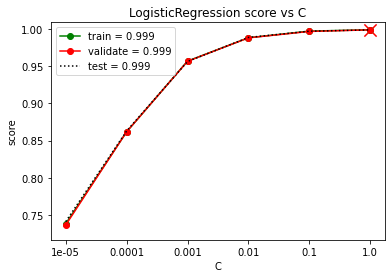

In [19]:
%%time
logistic = train_estimators(X_trn, ytrn, sklearn.linear_model.LogisticRegression,
                                   'C', [1e-05, 0.0001, 0.001, 0.01, 0.1,1.0], max_iter=10000,random_state=0)
plot_estimator_scores(logistic,'C',[1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0])

In [20]:
%%time
import warnings
warnings.filterwarnings('ignore', 'Solver terminated early.*')
svm = train_estimators(X_trn, ytrn, sklearn.svm.SVC,
                                   'C', [0.01, 0.1,1.0, 10.0, 100.0,1000.0], gamma=0.001,max_iter=100,random_state=0)

 Training SVC(C=0.01, gamma=0.001, max_iter=100, random_state=0)...
 Training SVC(C=0.1, gamma=0.001, max_iter=100, random_state=0)...
 Training SVC(gamma=0.001, max_iter=100, random_state=0)...
 Training SVC(C=10.0, gamma=0.001, max_iter=100, random_state=0)...
 Training SVC(C=100.0, gamma=0.001, max_iter=100, random_state=0)...
 Training SVC(C=1000.0, gamma=0.001, max_iter=100, random_state=0)...
CPU times: user 38 s, sys: 1.59 s, total: 39.6 s
Wall time: 44.2 s


CPU times: user 2min, sys: 411 ms, total: 2min 1s
Wall time: 2min 3s


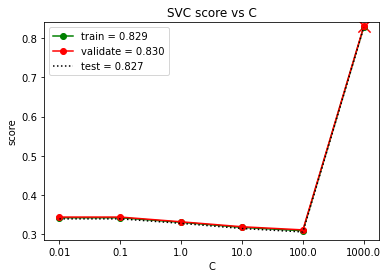

In [21]:
%%time
plot_estimator_scores(svm,'C',[0.01, 0.1,1.0, 10.0, 100.0,1000.0])

In [22]:
X = data.drop(["date","ticker","tomorrw_is_buy","tomorrow_is_strong_buy","week_is_buy","week_is_strong_buy","4week_is_buy","4week_is_strong_buy"],axis=1)
y = data["4week_is_buy"]
X = X.values
y = y.values
#split data into 60-20-20
#test set
x_remaining, Xtest, y_remaining, ytest = sklearn.model_selection.train_test_split(X, y, test_size=0.20,
                                                                                  random_state=0)
#validation and training set
Xtrn, Xval, ytrn, yval = sklearn.model_selection.train_test_split(x_remaining, y_remaining, test_size=0.25,
                                                                  random_state=0)

#scaling values 
scaler = sklearn.preprocessing.StandardScaler()
X_trn = scaler.fit_transform(Xtrn.reshape(Xtrn.shape[0],-1))
X_test = scaler.transform(Xtest.reshape(Xtest.shape[0],-1))
X_val = scaler.transform(Xval.reshape(Xval.shape[0],-1))

 Training DecisionTreeClassifier(max_depth=1, random_state=0, splitter='random')...
 Training DecisionTreeClassifier(max_depth=5, random_state=0, splitter='random')...
 Training DecisionTreeClassifier(max_depth=10, random_state=0, splitter='random')...
 Training DecisionTreeClassifier(max_depth=20, random_state=0, splitter='random')...
 Training DecisionTreeClassifier(max_depth=50, random_state=0, splitter='random')...
 Training DecisionTreeClassifier(max_depth=100, random_state=0, splitter='random')...
CPU times: user 12.2 s, sys: 180 ms, total: 12.4 s
Wall time: 13 s


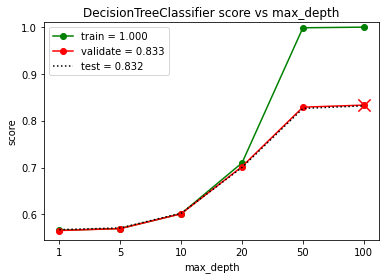

In [23]:
%%time
tree_estimators = train_estimators(X_trn, ytrn, sklearn.tree.DecisionTreeClassifier,
                                   'max_depth', [1, 5, 10, 20, 50, 100], splitter='random', random_state=0)
plot_estimator_scores(tree_estimators,'max_depth',[1, 5, 10, 20, 50, 100])

In [24]:
%%time
forest = train_estimators(X_trn, ytrn, sklearn.ensemble.RandomForestClassifier,
                                   'max_depth', [1, 5, 10, 20, 50, 100], random_state=0)

 Training RandomForestClassifier(max_depth=1, random_state=0)...
 Training RandomForestClassifier(max_depth=5, random_state=0)...
 Training RandomForestClassifier(max_depth=10, random_state=0)...
 Training RandomForestClassifier(max_depth=20, random_state=0)...
 Training RandomForestClassifier(max_depth=50, random_state=0)...
 Training RandomForestClassifier(max_depth=100, random_state=0)...
CPU times: user 11min 6s, sys: 5.72 s, total: 11min 11s
Wall time: 11min 36s


CPU times: user 1min 22s, sys: 4.72 s, total: 1min 26s
Wall time: 1min 29s


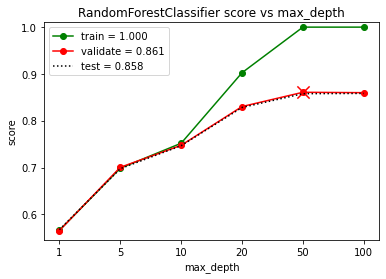

In [25]:
%%time
plot_estimator_scores(forest,'max_depth',[1, 5, 10, 20, 50, 100])

 Training LogisticRegression(C=1e-05, max_iter=10000, random_state=0)...
 Training LogisticRegression(C=0.0001, max_iter=10000, random_state=0)...
 Training LogisticRegression(C=0.001, max_iter=10000, random_state=0)...
 Training LogisticRegression(C=0.01, max_iter=10000, random_state=0)...
 Training LogisticRegression(C=0.1, max_iter=10000, random_state=0)...
 Training LogisticRegression(max_iter=10000, random_state=0)...
CPU times: user 6.06 s, sys: 359 ms, total: 6.42 s
Wall time: 4.73 s


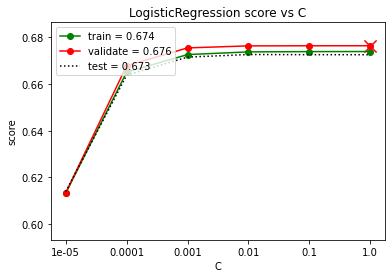

In [26]:
%%time
logistic = train_estimators(X_trn, ytrn, sklearn.linear_model.LogisticRegression,
                                   'C', [1e-05, 0.0001, 0.001, 0.01, 0.1,1.0], max_iter=10000,random_state=0)
plot_estimator_scores(logistic,'C',[1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0])

In [27]:
%%time
import warnings
warnings.filterwarnings('ignore', 'Solver terminated early.*')
svm = train_estimators(X_trn, ytrn, sklearn.svm.SVC,
                                   'C', [0.01, 0.1,1.0, 10.0, 100.0,1000.0], gamma=0.001,max_iter=100,random_state=0)

 Training SVC(C=0.01, gamma=0.001, max_iter=100, random_state=0)...
 Training SVC(C=0.1, gamma=0.001, max_iter=100, random_state=0)...
 Training SVC(gamma=0.001, max_iter=100, random_state=0)...
 Training SVC(C=10.0, gamma=0.001, max_iter=100, random_state=0)...
 Training SVC(C=100.0, gamma=0.001, max_iter=100, random_state=0)...
 Training SVC(C=1000.0, gamma=0.001, max_iter=100, random_state=0)...
CPU times: user 39.1 s, sys: 1.7 s, total: 40.8 s
Wall time: 43.8 s


CPU times: user 2min 16s, sys: 743 ms, total: 2min 16s
Wall time: 2min 23s


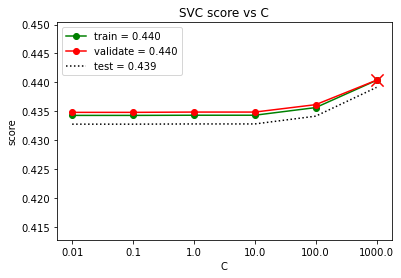

In [28]:
%%time
plot_estimator_scores(svm,'C',[0.01, 0.1,1.0, 10.0, 100.0,1000.0])